In [8]:
import cv2
import numpy as np
import time

# 开始计时
start_time = time.time()


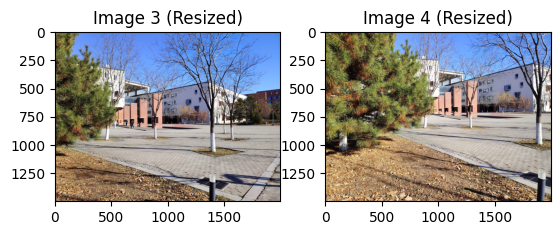

In [9]:
# 读取图像并调整大小
img1 = cv2.imread('3.jpg')  # 第一张图片
img2 = cv2.imread('4.jpg')  # 第二张图片
scale_percent = 50  # 缩放比例
img1 = cv2.resize(img1, None, fx=scale_percent / 100, fy=scale_percent / 100, interpolation=cv2.INTER_AREA)
img2 = cv2.resize(img2, None, fx=scale_percent / 100, fy=scale_percent / 100, interpolation=cv2.INTER_AREA)

# 显示调整大小后的图像
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('Image 3 (Resized)')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('Image 4 (Resized)')
plt.show()


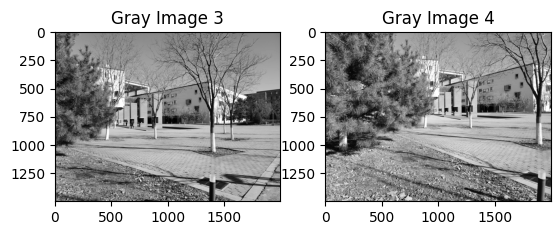

In [10]:
# 图像预处理：转换为灰度图像
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# 显示灰度图像
plt.subplot(1, 2, 1), plt.imshow(gray1, cmap='gray'), plt.title('Gray Image 3')
plt.subplot(1, 2, 2), plt.imshow(gray2, cmap='gray'), plt.title('Gray Image 4')
plt.show()


图像 3 的特征点数量: 500
图像 4 的特征点数量: 502


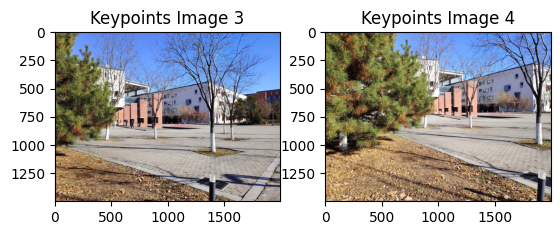

In [11]:
# 特征点提取与描述符计算
sift = cv2.SIFT_create(nfeatures=500)  # 限制特征点数量
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

# 输出特征点数量
print(f"图像 3 的特征点数量: {len(keypoints1)}")
print(f"图像 4 的特征点数量: {len(keypoints2)}")

# 绘制特征点
img_kp1 = cv2.drawKeypoints(img1, keypoints1, None)
img_kp2 = cv2.drawKeypoints(img2, keypoints2, None)

# 显示特征点
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB)), plt.title('Keypoints Image 3')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(img_kp2, cv2.COLOR_BGR2RGB)), plt.title('Keypoints Image 4')
plt.show()


筛选后的良好匹配数量: 130


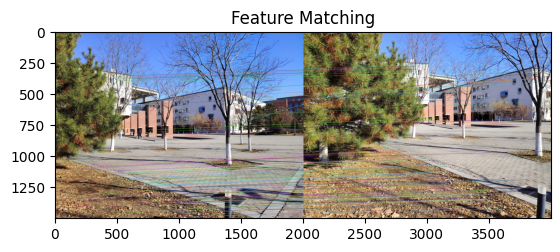

In [12]:
# 特征点匹配
index_params = dict(algorithm=1, trees=5)  # 使用KDTree算法
search_params = dict(checks=50)  # 传递检查数
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# 使用比率测试筛选匹配点
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # 比较最好的匹配与次好的匹配，保留最好的
        good_matches.append(m)

# 输出筛选后的匹配数量
print(f"筛选后的良好匹配数量: {len(good_matches)}")

# 绘制匹配结果
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# 显示匹配结果
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title('Feature Matching')
plt.show()


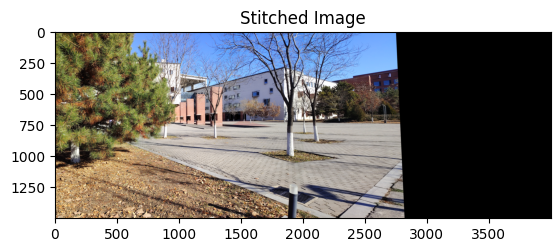

In [13]:
# 计算单应性矩阵
if len(good_matches) > 10:  # 确保足够的匹配点
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # 使用透视变换进行图像拼接
    height, width, channels = img2.shape
    result = cv2.warpPerspective(img1, H, (width + img1.shape[1], height))
    result[0:height, 0:width] = img2
else:
    result = img2  # 如果匹配点不足，返回原始图像

# 显示拼接结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.show()


In [14]:
# 停止计时
end_time = time.time()
processing_time = end_time - start_time
frame_rate = 1 / processing_time

# 输出结果
cv2.imwrite('result.jpg', result)
print(f"Processing Time: {processing_time:.2f} seconds")
print(f"Frame Rate: {frame_rate:.2f} FPS")


Processing Time: 4.95 seconds
Frame Rate: 0.20 FPS
